# Тюнинг линейной регрессии и ошибки

### О задании

В этом задании вы:
- обучите линейную регрессию, познакомитесь с метриками качества в задачах регресии

In [55]:
%pylab inline
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\magics\pylab.py:166: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Часть 1. Линейная регрессия

Для начала загрузим данные и разделим их на обучающую и тестовую выборки в соотношении 7 к 3. Зачем так делать? Когда вы проверяете себя на данных на которых не обучались, вы можете быть уверены что не переобучились. Таким образом если качество на 70% датасета (оубчающей выборке) растёт, а на тестовой выборке падает, то модель начала запоминать датасет (переобучилась), вы что-то делаете не так.


In [56]:
data = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

__Задание 1.__ Обучение линейной регрессии.

**(4 балла)**

Обучите линейную регрессию с $L_1$ (Lasso) и $L_2$ (Ridge) регуляризаторами (используйте параметры по умолчанию). Посмотрите, какое количество коэффициентов близко к 0 (степень близости к 0 определите сами из разумных пределов). Постройте график зависимости числа ненулевых коэффициентов от коэффицента регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$).

Спойлер - при большом гиперпараметре регуляризации все параметры стремятся к нулю. На графике это должно быть видно.

In [57]:
EPS = 2
alphas = []
for p in range(-3, 3):
     for i in range(1, 10):
         alpha = i * (10 ** p)
         alphas.append(alpha)


In [58]:
def f(alpha):
    regression = linear_model.Lasso(alpha=alpha)
    regression.fit(X_train, y_train)
    prediction = regression.predict(X_test)
    ret = 0
    for i in regression.coef_:
        ret += i < 0.1
    return ret

Lasso_cnts = Parallel(n_jobs=-1)(delayed(f)(alpha) for alpha in alphas)

In [59]:
def f(alpha):
    regression = linear_model.Ridge(alpha=alpha)
    regression.fit(X_train, y_train)
    prediction = regression.predict(X_test)
    ret = 0
    for i in regression.coef_:
        ret += abs(i) < 5
    return ret

Ridge_cnts = Parallel(n_jobs=-1)(delayed(f)(alpha) for alpha in alphas)

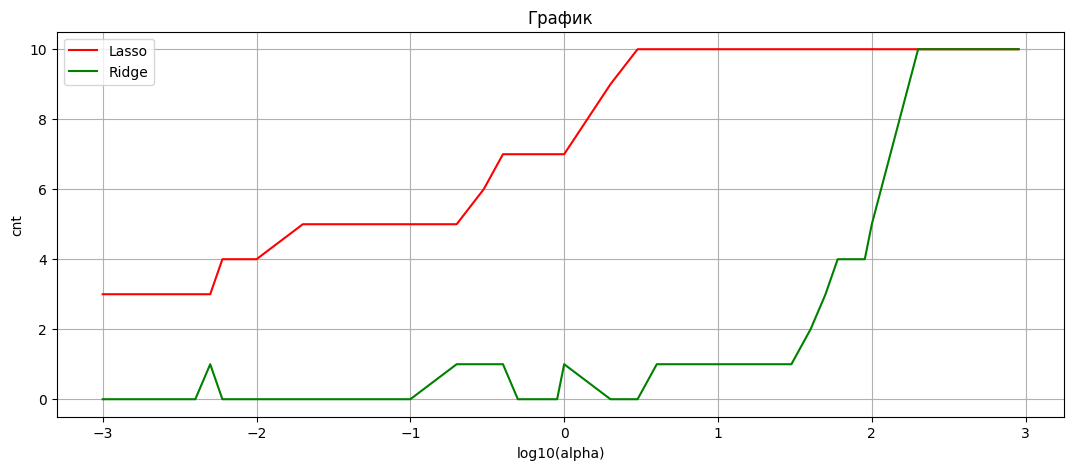

In [60]:
f, (ax) = plt.subplots(1, 1, figsize=(13, 5))
ax.plot([math.log(i, 10) for i in alphas], Lasso_cnts, label='Lasso', color='red')
ax.plot([math.log(i, 10) for i in alphas], Ridge_cnts, label='Ridge', color='green')
ax.set_title(u"График")
ax.set_xlabel(u"log10(alpha)")
ax.set_ylabel(u"cnt")
ax.grid()
ax.legend()

Посчитайте для Ridge-регрессии следующие метрики: $RMSE$, $MAE$, $R^2$.

In [61]:
model = linear_model.Ridge().fit(X_train, y_train)
p = model.predict(X_test)

print("mean_squared_error: ",mean_squared_error(y_test, p) ** 0.5)

print("mean_absolute_error: ", mean_absolute_error(y_test, p))

print("r2_score: ",r2_score(y_test, p))

mean_squared_error:  58.30429511391227
mean_absolute_error:  49.602750809651916
r2_score:  0.3599020220009461


Подберите на обучающей выборке для Ridge-регрессии коэффициент регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$) для каждой из метрик. Постройте графики зависимости фукнции потерь от коэффициента регуляризации. Посчитайте те же метрики снова. Заметно ли изменилось качество?

C:\Users\MSI\AppData\Local\Temp\ipykernel_7616\3801422414.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


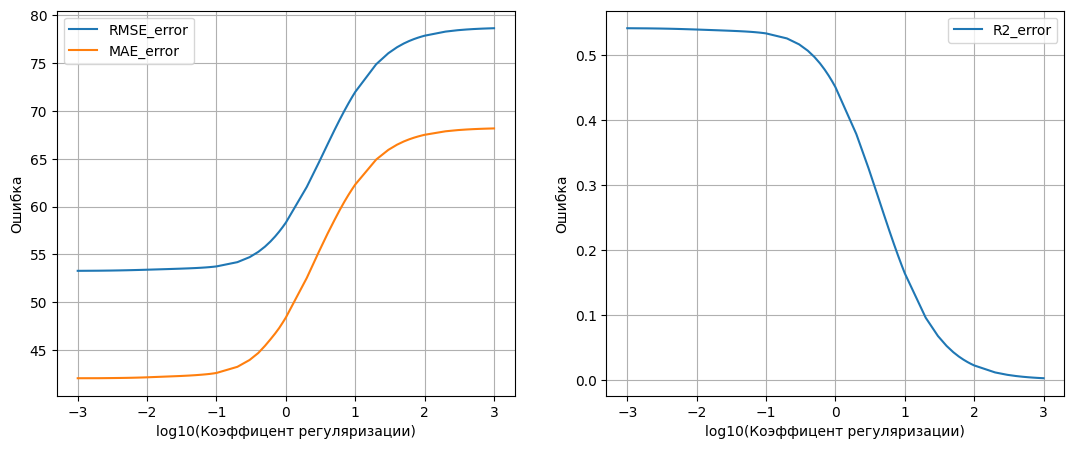

In [62]:
alphas = []
root_mean_squared_errors = []
mean_absolute_errors = []
r2_scores = []

for j in range (-3, 3):
    for i in range (1,11):
        alpha = i * (10 ** j)
        alphas.append(math.log(alpha, 10))
        l2 = linear_model.Ridge(alpha=alpha).fit(X_train, y_train)
        p2 = l2.predict(X_train)
        root_mean_squared_errors.append(mean_squared_error(y_train, p2) ** 0.5)
        mean_absolute_errors.append(mean_absolute_error(y_train, p2))
        r2_scores.append(r2_score(y_train, p2))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.plot(alphas, root_mean_squared_errors, label=u"RMSE_error")
ax1.plot(alphas, mean_absolute_errors, label=u"MAE_error")
ax1.set_xlabel(u"log10(Коэффицент регуляризации)")
ax1.set_ylabel(u"Ошибка")
ax1.grid()
ax1.legend()

ax2.plot(alphas, r2_scores, label=u"R2_error")
ax2.set_xlabel(u"log10(Коэффицент регуляризации)")
ax2.set_ylabel(u"Ошибка")
ax2.grid()
ax2.legend()

f.show()

In [63]:
model = linear_model.Ridge(alpha=0.001).fit(X_train, y_train)
p = model.predict(X_test)

print("mean_squared_error: ",mean_squared_error(y_test, p) ** 0.5)

print("mean_absolute_error: ", mean_absolute_error(y_test, p))

print("r2_score: ",r2_score(y_test, p))

mean_squared_error:  55.85755516261151
mean_absolute_error:  47.155429776130674
r2_score:  0.4124981979162933


__Задание 2.__ Поиск объектов-выбросов

**(4 балла)**

Как известно, MSE сильно штрафует за большие ошибки на объектах-выбросах. Посчитайте ошибки и посмотрите на их распределение (plt.hist). Что вы видите?

(array([66., 23., 16.,  7.,  9.,  7.,  0.,  3.,  1.,  1.]),
 array([4.22263004e+00, 1.73697759e+03, 3.46973255e+03, 5.20248752e+03,
        6.93524248e+03, 8.66799744e+03, 1.04007524e+04, 1.21335074e+04,
        1.38662623e+04, 1.55990173e+04, 1.73317722e+04]),
 <BarContainer object of 10 artists>)

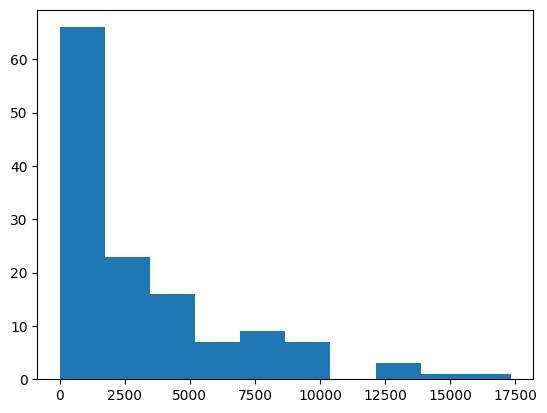

In [64]:
errors = []
for i in range(len(X_test)):
    errors.append(mean_squared_error([y_test[i]], [p[i]]))
plt.hist(errors)

# Так, что мы видим? Это медленно убывающая гистограмма. Напрашивается вывод, что ошибок с маленьким MSE довольно много и они встречаются чаще.

Попробуйте удалить объекты-выбросы из обучающей выборки (что считать или не считать выбросами на ваше усмотрение). Обучите модель заново и посмотрите на качество на отложенной выборке (учитывайте, что там тоже могут быть выбросы, с которыми вы ничего не можете сделать). Стало ли лучше? Чем вы можете объяснить это?

In [65]:
regression = linear_model.Ridge(alpha=0.1)
regression.fit(X_train, y_train)
prediction_train = regression.predict(X_train)

error_threshold = 6000
indexes = ((y_train - prediction_train) ** 2) <= error_threshold
new_x_train, new_y_train = X_train[indexes], y_train[indexes]

regression = linear_model.Ridge(alpha=0.1)
regression.fit(new_x_train, new_y_train)
prediction = regression.predict(X_test)

MSE = mean_squared_error(y_test, prediction)
RMSE = MSE ** 0.5
print("RMSE:", RMSE)

MAE = mean_absolute_error(y_test, prediction)
print("MAE:", MAE)

R2 = r2_score(y_test, prediction)
print("R2:", R2)

RMSE: 54.928619544017785
MAE: 46.33819639653926
R2: 0.4318765364891767


__Задание 3.__ Отчёт

**(2 балла)**

В результате нашей работы мы удалили объекты выбросы (которые смогли). RMSE и MSE уменьшились, стало лучше, спасибо линейной регрессии, а также моей команде, которая помогает днём и спит ночью